# Exploratory Data Analysis

In [1]:
import data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Specify database path
db = '../../data/database.sqlite'

### Filtering out unnecessary attributes and observations 

I began EDA by loading the required tables from the database specified above.

In [3]:
# Load data tables
country = data.read('country', db)
league = data.read('league', db)
match = data.read('match', db)
team = data.read('team', db)
team_attributes = data.read('team_attributes', db)

country: loaded
league: loaded
match: loaded
team: loaded
team_attributes: loaded


The predictive model will be fitted on just the English Premier League (EPL) match data. Note that `league_id` for EPL  is 1729. This variable can be changed to fit predictive models for other leagues. The code below filters out matches that were not played in EPL and attributes that are not required for the model.

In [4]:
# Initiate variable for EPL league ID 
league_id = 1729

# Create a column to specify which team won the match; this will server as the response variable in the model
epl_matches = match[(match['league_id'] == league_id)]
epl_matches['result'] = np.where(epl_matches['home_team_goal'] > epl_matches['away_team_goal'], 'home' , 
                        np.where(epl_matches['home_team_goal'] == epl_matches['away_team_goal'], 'draw' , 'away'))

# Create a field for season year
epl_matches['season_year'] = pd.to_numeric(epl_matches['season'].str[:4])

# Leave out unnecessary attributes
epl_matches = epl_matches[['match_api_id', 'league_id', 'season_year', 'home_team_api_id', 'away_team_api_id', 'result']].reset_index(drop = True)

epl_matches.head()

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,match_api_id,league_id,season_year,home_team_api_id,away_team_api_id,result
0,489042,1729,2008,10260,10261,draw
1,489043,1729,2008,9825,8659,home
2,489044,1729,2008,8472,8650,away
3,489045,1729,2008,8654,8528,home
4,489046,1729,2008,10252,8456,home


Next, team attribute table was filtered to just include EPL teams

In [5]:
# Create an mapping of EPL teams 
epl_mapping = pd.DataFrame(pd.concat([epl_matches['home_team_api_id'], epl_matches['away_team_api_id']], ignore_index = True).unique())
epl_mapping.columns = ['team_api_id']

# Filter out data to only include EPL teams
epl_teams = team_attributes.merge(epl_mapping, on = 'team_api_id', how = 'inner')

# Create a column for year
epl_teams['year'] = pd.DatetimeIndex(epl_teams['date']).year

# Add team name and drop other  unnecessary fields
epl_teams = epl_teams.merge(team[['team_api_id', 'team_long_name']], on = 'team_api_id', how = 'left').drop(['id', 'team_fifa_api_id', 'date'], axis = 1)

epl_teams.head()

,team_api_id,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,...,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,year,team_long_name
0,9825,66,Balanced,NaN,Little,30,Short,Free Form,30,Safe,...,Free Form,30,Deep,40,Press,50,Normal,Cover,2010,Arsenal
1,9825,75,Fast,NaN,Little,40,Mixed,Free Form,40,Normal,...,Free Form,50,Medium,40,Press,45,Normal,Cover,2011,Arsenal
2,9825,25,Slow,NaN,Little,32,Short,Organised,41,Normal,...,Free Form,57,Medium,57,Press,52,Normal,Cover,2012,Arsenal
3,9825,30,Slow,NaN,Little,29,Short,Organised,41,Normal,...,Free Form,64,Medium,54,Press,52,Normal,Cover,2013,Arsenal
4,9825,59,Balanced,51.0,Normal,26,Short,Organised,28,Safe,...,Free Form,51,Medium,44,Press,52,Normal,Cover,2014,Arsenal


### Combine data tables

To build a classification model, I combined the two tables created above: `epl_teams` and `epl_matches`. To combine the tables, I joined the tables on both the team ID as well as season year. The inner join in this case was done twice to add team attributes for both the home and away teams. Finally, I removed fields that would not be considered in the model. 

In [6]:
# Add home team attributes
data = pd.merge(epl_matches, epl_teams, how = 'inner', left_on = ['home_team_api_id', 'season_year'], right_on = ['team_api_id', 'year'])
data = pd.merge(data, epl_teams, how = 'inner', left_on = ['away_team_api_id', 'season_year'], right_on = ['team_api_id', 'year'], suffixes = ('_home', '_away')) \
         .drop(['league_id', 'year_home', 'year_away', 'match_api_id', 'buildUpPlayDribbling_home', 'buildUpPlayDribbling_away', 'home_team_api_id', 'away_team_api_id', 'team_api_id_home', 'team_api_id_away'], axis = 1)
data.head()

,season_year,result,buildUpPlaySpeed_home,buildUpPlaySpeedClass_home,buildUpPlayDribblingClass_home,buildUpPlayPassing_home,buildUpPlayPassingClass_home,buildUpPlayPositioningClass_home,chanceCreationPassing_home,chanceCreationPassingClass_home,...,chanceCreationShootingClass_away,chanceCreationPositioningClass_away,defencePressure_away,defencePressureClass_away,defenceAggression_away,defenceAggressionClass_away,defenceTeamWidth_away,defenceTeamWidthClass_away,defenceDefenderLineClass_away,team_long_name_away
0,2010,home,70,Fast,Little,59,Mixed,Organised,65,Normal,...,Normal,Organised,30,Deep,70,Double,30,Narrow,Cover,West Ham United
1,2010,draw,55,Balanced,Little,70,Long,Organised,60,Normal,...,Normal,Organised,30,Deep,70,Double,30,Narrow,Cover,West Ham United
2,2010,home,55,Balanced,Little,70,Long,Organised,70,Risky,...,Normal,Organised,30,Deep,70,Double,30,Narrow,Cover,West Ham United
3,2010,home,70,Fast,Little,60,Mixed,Free Form,56,Normal,...,Normal,Organised,30,Deep,70,Double,30,Narrow,Cover,West Ham United
4,2010,home,50,Balanced,Little,35,Mixed,Organised,50,Normal,...,Normal,Organised,30,Deep,70,Double,30,Narrow,Cover,West Ham United


### Examine each categorical and numerical attributes

In [25]:
numerical = list(data.describe())
categorical = ['result', 'buildUpPlaySpeedClass_home', 'buildUpPlayDribblingClass_home', 
               'buildUpPlayPassingClass_home', 'buildUpPlayPositioningClass_home', 'chanceCreationPassingClass_home',
               'chanceCreationCrossingClass_home', 'chanceCreationShootingClass_home', 'chanceCreationPositioningClass_home',
               'defencePressureClass_home', 'defenceAggressionClass_home', 'defenceTeamWidthClass_home',
               'defenceDefenderLineClass_home', 'team_long_name_home', 'buildUpPlaySpeedClass_away',
               'buildUpPlayDribblingClass_away', 'buildUpPlayPassingClass_away', 'buildUpPlayPositioningClass_away', 
               'chanceCreationPassingClass_away', 'chanceCreationCrossingClass_away', 'chanceCreationShootingClass_away', 
               'chanceCreationPositioningClass_away','defencePressureClass_away', 'defenceAggressionClass_away',
               'defenceTeamWidthClass_away', 'defenceDefenderLineClass_away', 'team_long_name_away']

In [34]:
for i in categorical:
    data[i] = data[i].astype('category')

In [36]:
data.describe(include = ['category'])

,result,buildUpPlaySpeedClass_home,buildUpPlayDribblingClass_home,buildUpPlayPassingClass_home,buildUpPlayPositioningClass_home,chanceCreationPassingClass_home,chanceCreationCrossingClass_home,chanceCreationShootingClass_home,chanceCreationPositioningClass_home,defencePressureClass_home,...,buildUpPlayPositioningClass_away,chanceCreationPassingClass_away,chanceCreationCrossingClass_away,chanceCreationShootingClass_away,chanceCreationPositioningClass_away,defencePressureClass_away,defenceAggressionClass_away,defenceTeamWidthClass_away,defenceDefenderLineClass_away,team_long_name_away
count,2280,2280,2280,2280,2280,2280,2280,2280,2280,2280,...,2280,2280,2280,2280,2280,2280,2280,2280,2280,2280
unique,3,3,2,3,2,3,3,3,2,3,...,2,3,3,3,2,3,3,3,1,32
top,home,Balanced,Little,Mixed,Organised,Normal,Normal,Normal,Organised,Medium,...,Organised,Normal,Normal,Normal,Organised,Medium,Press,Normal,Cover,Liverpool
freq,1024,1786,1672,1672,2166,1843,1615,1900,1862,1957,...,2166,1843,1615,1900,1862,1957,2014,2166,2280,114


In [30]:
data.describe()

,season_year,buildUpPlaySpeed_home,buildUpPlayPassing_home,chanceCreationPassing_home,chanceCreationCrossing_home,chanceCreationShooting_home,defencePressure_home,defenceAggression_home,defenceTeamWidth_home,buildUpPlaySpeed_away,buildUpPlayPassing_away,chanceCreationPassing_away,chanceCreationCrossing_away,chanceCreationShooting_away,defencePressure_away,defenceAggression_away,defenceTeamWidth_away
count,2280.0000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000
mean,2012.5000,56.566667,52.141667,50.725000,57.283333,52.366667,44.775000,50.391667,50.825000,56.566667,52.141667,50.725000,57.283333,52.366667,44.775000,50.391667,50.825000
std,1.7082,10.772486,12.883881,11.235572,11.260936,11.180506,9.842943,10.734934,8.545549,10.772486,12.883881,11.235572,11.260936,11.180506,9.842943,10.734934,8.545549
min,2010.0000,25.000000,24.000000,28.000000,31.000000,24.000000,25.000000,31.000000,30.000000,25.000000,24.000000,28.000000,31.000000,24.000000,25.000000,31.000000,30.000000
25%,2011.0000,48.000000,43.500000,42.000000,50.000000,45.750000,38.000000,41.000000,45.000000,48.000000,43.500000,42.000000,50.000000,45.750000,38.000000,41.000000,45.000000
50%,2012.5000,58.500000,51.000000,49.500000,59.000000,54.000000,44.000000,50.000000,51.000000,58.500000,51.000000,49.500000,59.000000,54.000000,44.000000,50.000000,51.000000
75%,2014.0000,65.000000,61.000000,59.250000,68.250000,60.000000,50.250000,58.000000,56.000000,65.000000,61.000000,59.250000,68.250000,60.000000,50.250000,58.000000,56.000000
max,2015.0000,77.000000,80.000000,72.000000,76.000000,80.000000,70.000000,70.000000,70.000000,77.000000,80.000000,72.000000,76.000000,80.000000,70.000000,70.000000,70.000000


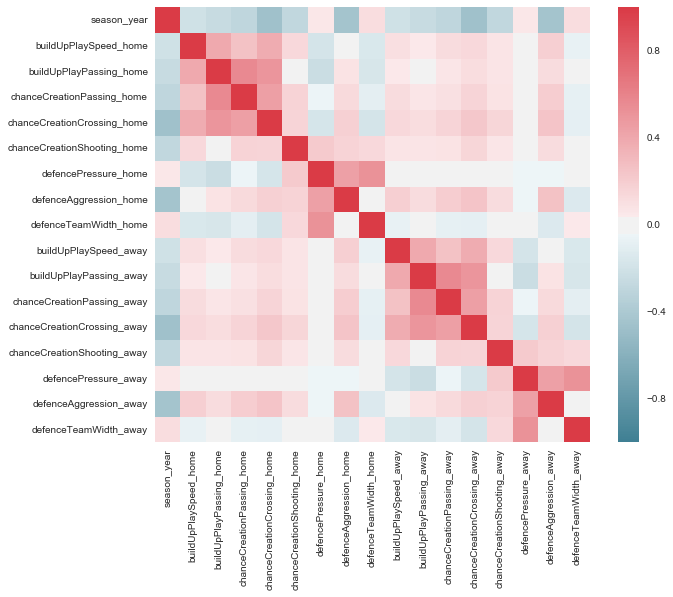

In [10]:
f, ax = plt.subplots(figsize=(10, 8))
corr = data.corr()
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap = True), square = True, ax = ax)
plt.show()